In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [2]:
review_data_path = 'amazon_reviews_us_Books_v1_02.tsv'

reviews = pd.read_table(review_data_path, error_bad_lines=False, encoding='utf-8')

reviews.head()

b'Skipping line 1680001: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4.0,2.0,3.0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3.0,5.0,5.0,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4.0,1.0,22.0,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5.0,2.0,2.0,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4.0,0.0,2.0,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


In [3]:
def partition(x):
    if x<3:
        return 'Negative'
    elif x>3:
        return 'Positive'
    return 'Neutral'

actualScore = reviews['star_rating']
positiveNegative = actualScore.map(partition)
reviews['Score'] = positiveNegative

In [4]:
reviews['Time'] = reviews['review_date']
sortedData = reviews.sort_values('product_id',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"customer_id","Time","review_body"},keep="first",inplace=False)

final = final[final.helpful_votes >= final.total_votes-final.helpful_votes]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'Positive']
finalp = finalp.sample(frac=0.008,random_state=2) #0.055

finaln = final[final.Score == 'Negative']
finaln = finaln.sample(frac=0.1,random_state=1) #0.25

finalne = final[final.Score == 'Neutral']
finalne = finalne.sample(frac=0.02,random_state=4) #0.25

final = pd.concat([finalp,finaln, finalne],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


In [5]:
import re
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
all_neutral_words=[]
s=''

for sent in final['review_body'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    if(final['Score'].values)[i] == 'Neutral':
                        all_neutral_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [6]:
from sklearn.model_selection import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=8)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

In [8]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )

In [9]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

"""
df_test = pd.read_csv('test.csv')

df_test = df_test.dropna()

X_test = df_test['review_body']
y_test = df_test['ratings']

count_vect_test = CountVectorizer() 
final_bow_count_test = count_vect.fit_transform(X_test)
final_bow_np_test = StandardScaler(with_mean=False).fit_transform(final_bow_count_test)

X_test = final_bow_np_test
"""

"\ndf_test = pd.read_csv('test.csv')\n\ndf_test = df_test.dropna()\n\nX_test = df_test['review_body']\ny_test = df_test['ratings']\n\ncount_vect_test = CountVectorizer() \nfinal_bow_count_test = count_vect.fit_transform(X_test)\nfinal_bow_np_test = StandardScaler(with_mean=False).fit_transform(final_bow_count_test)\n\nX_test = final_bow_np_test\n"


The optimal number of neighbors is 7.
the misclassification error for each k value is :  [0.486 0.443 0.426 0.421 0.422 0.424 0.422]


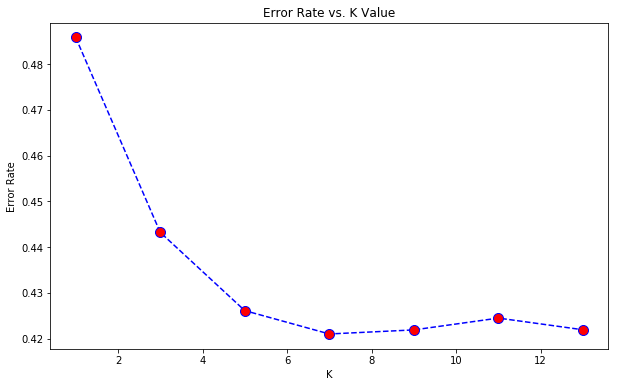

In [10]:
myList = list(range(0,15))

optimal_k = find_optimal_k(X_train ,y_train,myList)

In [11]:
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=8)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [12]:
print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Bag of words is  0.578
